In [185]:
from mlsolver.kripke import World, KripkeStructure
from graphviz import Digraph

In [2]:
worlds = [
 World('RRW', {'1:R': True, '2:R': True, '3:W': True}),
 World('RRR', {'1:R': True, '2:R': True, '3:R': True}),
 World('WRR', {'1:W': True, '2:R': True, '3:R': True}),

    World('WWR', {'1:W': True, '2:W': True, '3:R': True}),
 World('RWR', {'1:R': True, '2:W': True, '3:R': True}),
 World('WRW', {'1:W': True, '2:R': True, '3:W': True}),
]

relations = {
 '1': {('RRW', 'WRW'), ('RWR', 'WWR'), ('WRR', 'RRR')},
 '2': {('RWR', 'RRR'), ('WRR', 'WWR')},
 '3': {('RRR', 'RRW'), ('WRW', 'WRR')}
}
ks = KripkeStructure(worlds, relations)
print(ks)

(W = {(RRW,{'1:R': True, '2:R': True, '3:W': True})(RRR,{'1:R': True, '2:R': True, '3:R': True})(WRR,{'1:W': True, '2:R': True, '3:R': True})(WWR,{'1:W': True, '2:W': True, '3:R': True})(RWR,{'1:R': True, '2:W': True, '3:R': True})(WRW,{'1:W': True, '2:R': True, '3:W': True})}, R = {'1': {('RRW', 'WRW'), ('WRR', 'RRR'), ('RWR', 'WWR')}, '2': {('WRR', 'WWR'), ('RWR', 'RRR')}, '3': {('RRR', 'RRW'), ('WRW', 'WRR')}})


In [3]:
from mlsolver.formula import Atom, Box, Or, Box_a, And, Not
formula = Atom('1:R')
model2 = ks.solve(formula)

In [4]:
print(model2)

(W = {(RRW,{'1:R': True, '2:R': True, '3:W': True})(RRR,{'1:R': True, '2:R': True, '3:R': True})(RWR,{'1:R': True, '2:W': True, '3:R': True})}, R = {'1': set(), '2': {('RWR', 'RRR')}, '3': {('RRR', 'RRW')}})


In [5]:
print(ks)

(W = {(RRW,{'1:R': True, '2:R': True, '3:W': True})(RRR,{'1:R': True, '2:R': True, '3:R': True})(WRR,{'1:W': True, '2:R': True, '3:R': True})(WWR,{'1:W': True, '2:W': True, '3:R': True})(RWR,{'1:R': True, '2:W': True, '3:R': True})(WRW,{'1:W': True, '2:R': True, '3:W': True})}, R = {'1': {('RRW', 'WRW'), ('WRR', 'RRR'), ('RWR', 'WWR')}, '2': {('WRR', 'WWR'), ('RWR', 'RRR')}, '3': {('RRR', 'RRW'), ('WRW', 'WRR')}})


In [224]:
class AmongUs(object):
    def __init__(self, num_agents, imposter):
        self.worlds = []
        self.relations = {}
        

        # Build the same number of worlds as there are agents. Each world has one imposter
        for i in range(num_agents):
            agent_is_imposter = {}
            for j in range(num_agents):
                if i == j:
                    agent_is_imposter["IsImp:{}".format(j)] = True
                else:
                    agent_is_imposter["IsImp:{}".format(j)] = False

            self.worlds.append(World("Imp{}".format(i), agent_is_imposter))

        # Build relations according to the following rules:
        # Each agent knows whether they themselves are imposter or not
        # This leads to crewmates not having accessibility to the worlds where they are imposter
        # This leads to imposters only having a reflexive relation to themselves
        for i in range(num_agents):
            self.relations[str(i)] = set(("Imp{}".format(x),"Imp{}".format(y)) for x in range(num_agents) for y in range(num_agents) if ((i != x) and (i != y)))
        #print(self.relations)
        self.relations.update(add_symmetric_edges(self.relations))

        self.kripke_structure = KripkeStructure(self.worlds, self.relations)
        self.real_world = "Imp{}".format(imposter)
    def suspects(self, observer, other):
        """ Check if agent i suspects agent j of being the impostor
        We do this by evaluating the sentence "i knows not "IsImp:j" 
        """
        sentence = Not(Box_a(str(observer), Not(Atom("IsImp:{}".format(other)))))
        return sentence.semantic(self.kripke_structure, self.real_world)
    def update_known_impostor(self, observer, impostor):
        """Update the model to register that a crewmate has caught the impostor
        """
        sentence = Box_a(str(observer), Atom("IsImp:{}".format(impostor)))
        self.kripke_structure = kripke_structure_solve_a(self.kripke_structure, str(observer), sentence)
    def update_known_crewmate(self, observer, crewmate):
        """Update the model to register that a crewmate no longer suspects another crewmate
        (e.g. because of a visual task)
        """
        sentence = Box_a(str(observer), Not(Atom("IsImp:{}".format(crewmate))))
        self.kripke_structure = kripke_structure_solve_a(self.kripke_structure, str(observer), sentence)
    def plot(self):
        dot = Digraph(comment='The Round Table')
        dot.node('A', 'Test')
        return dot

In [225]:
def add_reflexive_edges(worlds, relations):
    """Routine adds reflexive edges to Kripke frame
    """
    result = {}
    for agent, agents_relations in relations.items():
        result_agents = agents_relations.copy()
        for world in worlds:
            result_agents.add((world.name, world.name))
            result[agent] = result_agents
    return result

def add_symmetric_edges(relations):
    """Routine adds symmetric edges to Kripke frame
    """
    result = {}
    for agent, agents_relations in relations.items():
        result_agents = agents_relations.copy()
        for r in agents_relations:
            x, y = r[1], r[0]
            result_agents.add((x, y))
        result[agent] = result_agents
    return result
def kripke_structure_solve_a(self, agent, formula):
    """ This function was taken from the code of The Ship at 
    https://github.com/JohnRoyale/MAS2018/blob/master/mlsolver/kripke.py#L36
    it is necessary to be able to execute models for only one agent
    """
    nodes_to_remove = self.nodes_not_follow_formula(formula)

    if len(nodes_to_remove) == 0:
        return self

    relations_to_remove = []

    for relation in self.relations[str(agent)]:
        for node in nodes_to_remove: 
            if node in relation:
                relations_to_remove.append(relation)
                break

    self.relations[str(agent)] = self.relations[str(agent)].difference(set(relations_to_remove))

    return self

(W = {(Imp0,{'IsImp:0': True, 'IsImp:1': False, 'IsImp:2': False, 'IsImp:3': False})(Imp1,{'IsImp:0': False, 'IsImp:1': True, 'IsImp:2': False, 'IsImp:3': False})(Imp2,{'IsImp:0': False, 'IsImp:1': False, 'IsImp:2': True, 'IsImp:3': False})(Imp3,{'IsImp:0': False, 'IsImp:1': False, 'IsImp:2': False, 'IsImp:3': True})}, R = {'0': {('Imp2', 'Imp1'), ('Imp3', 'Imp3'), ('Imp1', 'Imp1'), ('Imp3', 'Imp2'), ('Imp3', 'Imp1'), ('Imp2', 'Imp3'), ('Imp2', 'Imp2'), ('Imp1', 'Imp3'), ('Imp1', 'Imp2')}, '1': {('Imp0', 'Imp3'), ('Imp0', 'Imp0'), ('Imp0', 'Imp2'), ('Imp3', 'Imp0'), ('Imp3', 'Imp3'), ('Imp3', 'Imp2'), ('Imp2', 'Imp2'), ('Imp2', 'Imp3'), ('Imp2', 'Imp0')}, '2': {('Imp0', 'Imp3'), ('Imp0', 'Imp0'), ('Imp3', 'Imp3'), ('Imp3', 'Imp0'), ('Imp1', 'Imp1'), ('Imp0', 'Imp1'), ('Imp3', 'Imp1'), ('Imp1', 'Imp3'), ('Imp1', 'Imp0')}, '3': {('Imp1', 'Imp2'), ('Imp2', 'Imp1'), ('Imp0', 'Imp0'), ('Imp0', 'Imp2'), ('Imp1', 'Imp1'), ('Imp0', 'Imp1'), ('Imp2', 'Imp2'), ('Imp2', 'Imp0'), ('Imp1', 'Imp0')}

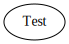

In [226]:
model = AmongUs(4, 2)
print(model.kripke_structure)
model.plot()

In [227]:
model = AmongUs(4, 2)
for i in range(4):
    for j in range(4):
        if model.suspects(i, j):
            print("{} suspects {} of being the impostor".format(i, j))
        else:
            print("{} does not suspect {} of being the impostor".format(i, j))
print("\n\nUPDATE: 1 catches 2")

model.update_known_impostor(1, 2)
for i in range(4):
    for j in range(4):
        if model.suspects(i, j):
            print("{} suspects {} of being the impostor".format(i, j))
        else:
            print("{} does not suspect {} of being the impostor".format(i, j))
print("\n\nUPDATE: 3 sees visual task of 0")
model.update_known_crewmate(3, 0)
for i in range(4):
    for j in range(4):
        if model.suspects(i, j):
            print("{} suspects {} of being the impostor".format(i, j))
        else:
            print("{} does not suspect {} of being the impostor".format(i, j))
print("\n\nUPDATE: 3 sees visual task of 1")
model.update_known_crewmate(3, 1)
for i in range(4):
    for j in range(4):
        if model.suspects(i, j):
            print("{} suspects {} of being the impostor".format(i, j))
        else:
            print("{} does not suspect {} of being the impostor".format(i, j))

0 does not suspect 0 of being the impostor
0 suspects 1 of being the impostor
0 suspects 2 of being the impostor
0 suspects 3 of being the impostor
1 suspects 0 of being the impostor
1 does not suspect 1 of being the impostor
1 suspects 2 of being the impostor
1 suspects 3 of being the impostor
2 does not suspect 0 of being the impostor
2 does not suspect 1 of being the impostor
2 does not suspect 2 of being the impostor
2 does not suspect 3 of being the impostor
3 suspects 0 of being the impostor
3 suspects 1 of being the impostor
3 suspects 2 of being the impostor
3 does not suspect 3 of being the impostor


UPDATE: 1 catches 2
0 does not suspect 0 of being the impostor
0 suspects 1 of being the impostor
0 suspects 2 of being the impostor
0 suspects 3 of being the impostor
1 does not suspect 0 of being the impostor
1 does not suspect 1 of being the impostor
1 does not suspect 2 of being the impostor
1 does not suspect 3 of being the impostor
2 does not suspect 0 of being the impostor

In [218]:

print(sentence.semantic(model.kripke_structure, "Imp1"))
print(sentence.semantic(model.kripke_structure, "Imp2"))


False
True


In [168]:
print(model.kripke_structure)

(W = {(Imp2,{'IsImp:0': False, 'IsImp:1': False, 'IsImp:2': True, 'IsImp:3': False})}, R = {0: {('Imp2', 'Imp2')}, 1: {('Imp2', 'Imp2')}, 2: {('Imp2', 'Imp2')}, 3: {('Imp2', 'Imp2')}})


In [140]:
print(model.kripke_structure)

(W = {(Imp0,{'IsImp:0': True, 'IsImp:1': False, 'IsImp:2': False})(Imp1,{'IsImp:0': False, 'IsImp:1': True, 'IsImp:2': False})(Imp2,{'IsImp:0': False, 'IsImp:1': False, 'IsImp:2': True})}, R = {0: {('Imp2', 'Imp2'), ('Imp1', 'Imp1'), ('Imp2', 'Imp1'), ('Imp1', 'Imp2')}, 1: {('Imp2', 'Imp0'), ('Imp0', 'Imp0'), ('Imp0', 'Imp2'), ('Imp2', 'Imp2')}, 2: {('Imp2', 'Imp2')}})


In [34]:
formula = Box_a(1, Not(Atom('IsImp:0')))
ks2 = model.kripke_structure.solve(formula)

In [27]:
print(ks2)

(W = {(Imp1,{'IsImp:0': False, 'IsImp:1': True, 'IsImp:2': False, 'IsImp:3': False, 'IsImp:4': False})(Imp2,{'IsImp:0': False, 'IsImp:1': False, 'IsImp:2': True, 'IsImp:3': False, 'IsImp:4': False})(Imp3,{'IsImp:0': False, 'IsImp:1': False, 'IsImp:2': False, 'IsImp:3': True, 'IsImp:4': False})(Imp4,{'IsImp:0': False, 'IsImp:1': False, 'IsImp:2': False, 'IsImp:3': False, 'IsImp:4': True})}, R = {0: {('Imp4', 'Imp3'), ('Imp4', 'Imp2'), ('Imp2', 'Imp4'), ('Imp3', 'Imp3'), ('Imp2', 'Imp1'), ('Imp3', 'Imp4'), ('Imp1', 'Imp4'), ('Imp1', 'Imp1'), ('Imp3', 'Imp2'), ('Imp4', 'Imp4'), ('Imp4', 'Imp1'), ('Imp2', 'Imp3'), ('Imp3', 'Imp1'), ('Imp2', 'Imp2'), ('Imp1', 'Imp3'), ('Imp1', 'Imp2')}, 1: {('Imp4', 'Imp3'), ('Imp4', 'Imp2'), ('Imp2', 'Imp4'), ('Imp3', 'Imp3'), ('Imp3', 'Imp4'), ('Imp3', 'Imp2'), ('Imp4', 'Imp4'), ('Imp2', 'Imp2'), ('Imp2', 'Imp3')}, 2: {('Imp4', 'Imp3'), ('Imp3', 'Imp3'), ('Imp3', 'Imp4'), ('Imp1', 'Imp4'), ('Imp1', 'Imp1'), ('Imp4', 'Imp4'), ('Imp4', 'Imp1'), ('Imp3', 'Im

In [178]:
i = 2
num_agents = 4
set(("Imp{}".format(x),"Imp{}".format(y)) for x in range(num_agents) for y in range(num_agents) if ((i != x) and (i != y)))

{('Imp0', 'Imp0'),
 ('Imp0', 'Imp1'),
 ('Imp0', 'Imp3'),
 ('Imp1', 'Imp0'),
 ('Imp1', 'Imp1'),
 ('Imp1', 'Imp3'),
 ('Imp3', 'Imp0'),
 ('Imp3', 'Imp1'),
 ('Imp3', 'Imp3')}